In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras

In [4]:
!pip install tensorflow

In [5]:
!pip install opencv-python

In [6]:
!pip install --upgrade tensorflow-hub

In [7]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=fa283c1c57e3976f3c033a88f6cd44c3edf35d4fc3f2518cc3583fa52f8f54f2
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [8]:
!pip install tabulate

In [9]:
!pip install tqdm

In [10]:
import os
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs

In [11]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}


        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []

        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index

            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size = (img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)

        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)

        # stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(X, y,
                                                                                                   one_hot_y,
                                                                                                   test_size = test_size,
                                                                                                   random_state = seed,
                                                                                                   stratify = y)

In [12]:
data = Dataset("/content/drive/MyDrive/brain_tumor_dataset", test_size=0.2, img_size=256)
print(data.X.shape, data.y.shape)

(210, 256, 256, 3) (210, 2)


In [13]:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)

(210, 2048) (53, 2048)


In [14]:

def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float) -> tf.keras.Model:
    model = tf.keras.Sequential()


    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))

    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model

In [15]:
# Function for Evaluating the Model:
def evaluate_model(
    nclasses, X, y, X_dev, y_dev, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params) -> tuple:


    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)


    model = model_maker(nclasses, **model_params)
    model.compile(optimizer = Adam(learning_rate = ExponentialDecay(
                                                                    learning_rate,
                                                                    decay_steps = third_of_total_steps,
                                                                    decay_rate = 0.1,
                                                                    staircase = True
                                                                    )
                                   ),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"]
                 )

    # Train the model on the training set
    model.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = 0)

    _, train_acc = model.evaluate(X, y, batch_size = batch_size, verbose = 0)
    _, dev_acc = model.evaluate(X_dev, y_dev, batch_size = batch_size, verbose = 0)

    return model, train_acc, dev_acc

In [16]:
# Cross-Validating the evaluated model:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params) -> dict:



    _, nclasses = y.shape
    train_accs, dev_accs = [], []

    # Train and evaluate the model for each fold.
    for train_index, dev_index in tqdm(
        RepeatedStratifiedKFold(
                                n_splits = nfolds,
                                n_repeats = nrepeats,
                                random_state = seed).split(X, labels),
        total = nfolds*nrepeats, disable = not verbose):

        # data for the fold
        X_train_fold = tf.gather(X, train_index)
        y_train_fold = tf.gather(y, train_index)
        X_dev_fold = tf.gather(X, dev_index)
        y_dev_fold = tf.gather(y, dev_index)

        # Train and evaluate the model.
        _, train_acc, dev_acc = evaluate_model(
                                               nclasses,
                                               X_train_fold,
                                               y_train_fold,
                                               X_dev_fold,
                                               y_dev_fold,
                                               epochs = epochs,
                                               batch_size = batch_size,
                                               learning_rate = learning_rate,
                                               model_maker = model_maker,
                                               **model_params
                                               )

        train_accs.append(train_acc)
        dev_accs.append(dev_acc)


    results = {
               "train_mean": np.mean(train_accs),
               "train_std": np.std(train_accs),
               "dev_mean": np.mean(dev_accs),
               "dev_std": np.std(dev_accs)
              }


    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Dev", results["dev_mean"], results["dev_std"]]
                ],
                headers = ["Set", "Mean", "Std. Dev."]))

    return results

In [17]:
default_cv_evaluate_params = {
                              "X": X_embedding,
                              "y": data.y,
                              "labels": data.labels,
                              "nfolds": 5,
                              "nrepeats": 3,
                              "model_maker": make_model,
                              "epochs": 100,
                              "batch_size": 5,
                              "verbose": False,
                              "learning_rate": 3e-3,
                              "dropout_rate": 0.3,
                              "nhiddenunits": 64,
                              "l2_regularization": 1e-6
                              }

_ = cv_evaluate_model(**{**default_cv_evaluate_params, "verbose": True})

100%|██████████| 15/15 [02:58<00:00, 11.93s/it]

Set        Mean    Std. Dev.
-----  --------  -----------
Train  0.971825    0.0911697
Dev    0.853968    0.0786636


In [18]:
nsamples = 10

In [19]:
np.random.seed()
x = lhs(n=2, samples=nsamples)

In [20]:
dropout_rates = (x[:, 0]*.6)

In [21]:
l2_rates = (x[:, 1]*-7 - 1)

In [22]:
l2_rates = 10**l2_rates

In [ ]:
# cross validating our model on each hyperparameter sample,
dev_means = np.zeros((nsamples, 1))
dev_stds = np.zeros((nsamples, 1))

for i in tqdm(range(nsamples)):
    results = cv_evaluate_model(**{**default_cv_evaluate_params,
                                   "dropout_rate": dropout_rates[i],
                                   "l2_regularization": l2_rates[i]}
                               )

    dev_means[i] = results["dev_mean"]
    dev_stds[i] = results["dev_std"]

100%|██████████| 10/10 [36:51<00:00, 221.12s/it]


Best l2_rate:	0.0001249441715364574
Best dropout:	0.455252221098134


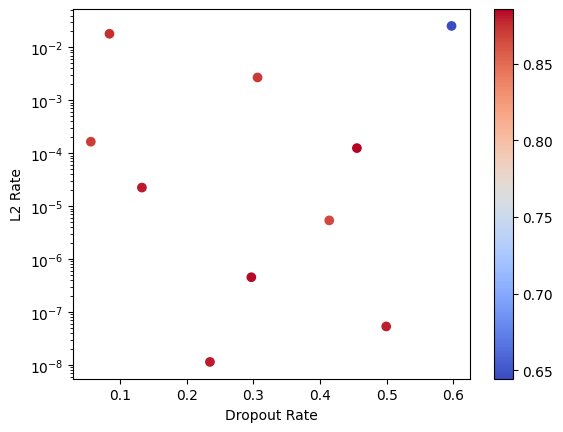

In [ ]:
# Visualizing the results over the hyperparameter space:
best_i = np.argmax(dev_means)
best_l2 = l2_rates[best_i]
print(f"Best l2_rate:\t{best_l2}")

best_dropout = dropout_rates[best_i]
print(f"Best dropout:\t{best_dropout}")

plt.scatter(dropout_rates, l2_rates, c=dev_means, cmap=plt.cm.coolwarm)
plt.xlabel("Dropout Rate")
plt.ylabel("L2 Rate")
plt.yscale("log")
plt.colorbar()
plt.show()

In [ ]:

default_cv_evaluate_params["dropout_rate"] = best_dropout
default_cv_evaluate_params["l2_regularization"] = best_l2

In [ ]:
# Searching for the best Hyperparameter:
def search_hyperparam(
    param_name: str, lower: int, upper: int, nsamples: int,
    scale: str = "float", **cv_evaluate_params) -> float:

    # Sample the hyperparameter values to try.
    param_values = np.linspace(lower, upper, nsamples)

    if scale == "log":
        param_values = 10**param_values
    elif scale == "int":
        param_values = param_values.astype(int)

    # Evaluate the model at each of the values.
    dev_means = np.zeros((nsamples, 1))
    dev_stds = np.zeros((nsamples, 1))

    for i in tqdm(range(nsamples)):
        results = cv_evaluate_model(**{**cv_evaluate_params, param_name: param_values[i]})
        dev_means[i] = results["dev_mean"]
        dev_stds[i] = results["dev_std"]

    # Find the best value.
    best_param_value = param_values[np.argmax(dev_means)]
    print(f"Best {param_name} value: {best_param_value}")

    # Plot scores achieved for all values.
    plt.plot(param_values, dev_means)
    plt.xlabel(param_name)
    plt.ylabel("Mean Dev Set Accuracy")

    if scale == "log":
        plt.xscale("log")

    plt.show()

    return best_param_value


100%|██████████| 10/10 [1:27:13<00:00, 523.37s/it]

Best epochs value: 150


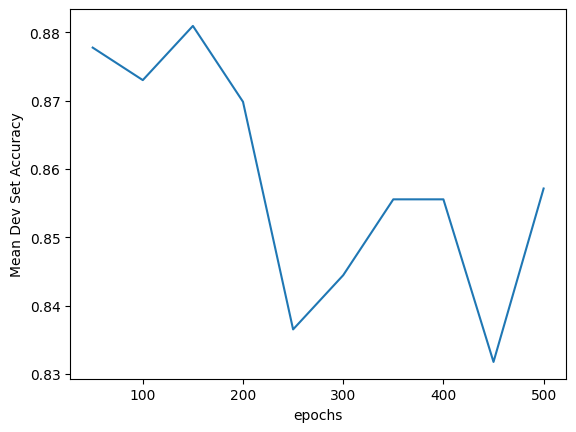

In [ ]:
# Searching over the number of epochs in the steps of 50 in range [50,500]:
best_epochs = search_hyperparam("epochs", 50, 500, 10, scale="int", **default_cv_evaluate_params)

In [ ]:
default_cv_evaluate_params["epochs"] = best_epochs

In [ ]:

def evaluate_final(params: dict) -> float:

    steps_per_epoch = math.ceil(len(X_embedding) / params["batch_size"])
    third_of_total_steps = math.floor(params["epochs"] * steps_per_epoch / 3)


    model = make_model(
                       data.nclasses,
                       dropout_rate = params["dropout_rate"],
                       nhiddenunits = params["nhiddenunits"],
                       l2_regularization = params["l2_regularization"]
                       )

    model.compile(optimizer = Adam(learning_rate = ExponentialDecay(
                                                                    params["learning_rate"],
                                                                    decay_steps = third_of_total_steps,
                                                                    decay_rate = 0.1,
                                                                    staircase = True
                                                                    )
                                  ),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"]
                 )


    model.fit(
              X_embedding,
              tf.convert_to_tensor(data.y),
              batch_size = params["batch_size"],
              epochs = params["epochs"],
              verbose = 0
              )

    # Evaluate the fitted model on the test set.
    _, test_acc = model.evaluate(
                                 X_test_embedding,
                                 data.y_test,
                                 verbose = 0
                                 )

    return test_acc

In [ ]:
test_acc = evaluate_final(default_cv_evaluate_params)
print(f"Final test set accuracy:\t{test_acc:.2f}")

Final test set accuracy:	0.85


In [ ]:
# Evaluating on the test set each time:
test_accs = []
for _ in tqdm(range(30)):
    test_accs.append(evaluate_final(default_cv_evaluate_params))

100%|██████████| 30/30 [09:38<00:00, 19.30s/it]


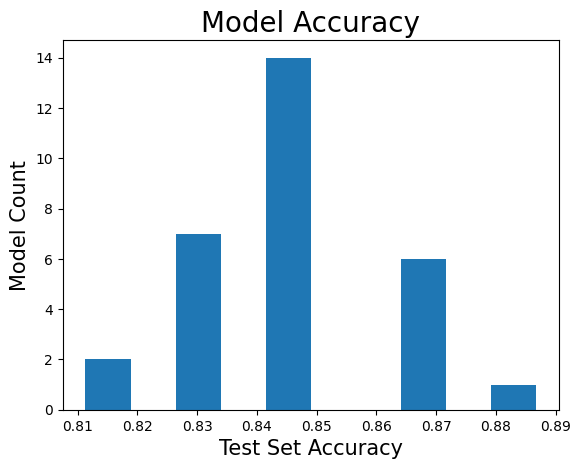

In [ ]:
# Plotting The test accuracy by training this model multiple times:
plt.hist(test_accs)
plt.title('Model Accuracy', fontsize = 20)
plt.xlabel("Test Set Accuracy", fontsize = 15)
plt.ylabel("Model Count", fontsize = 15)
plt.show()